# Обучение модели, с использованием эмбеддингов постов. 
Ноутбук выполнялся в kaggle.

In [1]:
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

import re
import sys
import gc
import os
from dotenv import load_dotenv

from tqdm import tqdm

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols):
    """ Создание,обучение и проверка модели CatBoostClassifier. """
    catboost = CatBoostClassifier(**params)
    catboost.fit(X_train, y_train, object_cols)
    
    print(f"ROC_AUC на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
    print(f"ROC_AUC на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

    y_pred = catboost.predict(X_test)
    y_pred_train = catboost.predict(X_train)
    print(f'Accuracy test {accuracy_score(y_test, y_pred)}, Accuracy train {accuracy_score(y_train, y_pred_train)}')
    
    return catboost

In [4]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,10))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [5]:
# Загружаем доступы к базе данных соцальной сети Karpov Courses
load_dotenv(r'/kaggle/input/karpov-startml-db/env')

True

In [6]:
POSTGRESUSER = os.environ['POSTGRESUSER']
POSTGRES_PASSWORD = os.environ['POSTGRES_PASSWORD']
POSTGRES_HOST = os.environ['POSTGRES_HOST']
POSTGRES_PORT = os.environ['POSTGRES_PORT']
POSTGRES_DATABASE = os.environ['POSTGRES_DATABASE']

In [7]:
str_con_db = f'postgresql://{POSTGRESUSER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DATABASE}'

In [8]:
engine = create_engine(str_con_db)

## Загрузка таблиц признаков пользователей и эмбеддингов постов.

In [9]:
# Загрузка таблицы признаков пользователей.
df_user_data = pd.read_sql("""SELECT * FROM pavel55645_users_lesson_22""", con=engine)
df_user_data = df_user_data.drop(['index'], axis=1)

In [10]:
df_user_data.head()

,user_id,gender,age,country,city,exp_group,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,0.071429,0.096774,0.285714,0.170455,0.068966,0.109375,0.153846
1,201,0,37,Russia,Abakan,0,0.103448,0.063953,0.121212,0.122677,0.013889,0.023256,0.137931
2,202,1,17,Russia,Smolensk,4,0.052632,0.139241,0.037037,0.126812,0.254237,0.168831,0.000000
3,203,0,18,Russia,Moscow,1,0.157895,0.183099,0.181818,0.182482,0.200000,0.224490,0.222222
4,204,0,36,Russia,Anzhero-Sudzhensk,3,0.125000,0.258065,0.200000,0.140625,0.100000,0.117647,0.333333


In [11]:
# Загрузка таблицы эмбеддингов постов.
df_post_text_emb = pd.read_sql("""SELECT * FROM pavel55645_posts_info_features_dl_emb""", con=engine)
df_post_text_emb = df_post_text_emb.drop(['index'], axis = 1)

In [12]:
df_post_text_emb.head()

,post_id,text,topic,text_feat_0,text_feat_1,text_feat_2,text_feat_3,text_feat_4,text_feat_5,text_feat_6,...,text_feat_758,text_feat_759,text_feat_760,text_feat_761,text_feat_762,text_feat_763,text_feat_764,text_feat_765,text_feat_766,text_feat_767
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.363151,0.048938,-0.264081,-0.160672,-0.211844,-0.207537,0.325393,...,0.349080,0.290132,-0.244970,0.078532,0.137399,0.208097,-0.058624,-0.141593,0.015918,0.000092
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.236416,-0.159501,-0.327798,-0.372885,-0.292128,-0.019028,0.333677,...,0.311639,0.297819,-0.177003,0.130227,-0.063239,0.190171,-0.018153,-0.289936,0.119365,-0.001623
2,3,Asian quake hits European shares\n\nShares in ...,business,0.375191,-0.113944,-0.240547,-0.282425,-0.264252,0.061839,0.249180,...,0.353616,0.308457,-0.207151,0.056724,0.056596,0.125301,0.021575,-0.338920,0.058694,-0.021266
3,4,India power shares jump on debut\n\nShares in ...,business,0.273770,-0.048748,-0.440433,-0.189999,-0.410856,-0.100587,0.255757,...,0.321182,0.218213,-0.267988,-0.093801,0.176987,0.251617,0.028331,-0.155708,0.136188,0.044055
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.297853,-0.073203,-0.146820,-0.127284,-0.133966,0.045766,0.176495,...,0.168949,0.208978,-0.051180,0.045685,0.173985,0.148893,0.097254,-0.239587,0.228066,0.189831


In [13]:
df_feed_data = pd.read_csv(r'/kaggle/input/karpov-startml-feed-data/feed_data.csv')

In [14]:
df_feed_data.head()

,timestamp,user_id,post_id,target
0,2021-12-15 12:19:13,15743,3907,0
1,2021-10-27 16:36:43,11962,222,1
2,2021-10-30 14:39:36,12328,1342,0
3,2021-10-02 12:58:57,12635,4313,0
4,2021-10-02 11:26:53,17258,4880,1


## Обработка эмбеддингов постов таблицы df_post_text_emb.

In [15]:
# Получаем эмбеддинги постов.
df_post_text_emb_ = df_post_text_emb.drop(['post_id', 'text', 'topic'], axis=1)

In [16]:
df_post_text_emb_.head()

,text_feat_0,text_feat_1,text_feat_2,text_feat_3,text_feat_4,text_feat_5,text_feat_6,text_feat_7,text_feat_8,text_feat_9,...,text_feat_758,text_feat_759,text_feat_760,text_feat_761,text_feat_762,text_feat_763,text_feat_764,text_feat_765,text_feat_766,text_feat_767
0,0.363151,0.048938,-0.264081,-0.160672,-0.211844,-0.207537,0.325393,-0.026139,0.087267,-1.041421,...,0.349080,0.290132,-0.244970,0.078532,0.137399,0.208097,-0.058624,-0.141593,0.015918,0.000092
1,0.236416,-0.159501,-0.327798,-0.372885,-0.292128,-0.019028,0.333677,-0.179642,0.004258,-1.027000,...,0.311639,0.297819,-0.177003,0.130227,-0.063239,0.190171,-0.018153,-0.289936,0.119365,-0.001623
2,0.375191,-0.113944,-0.240547,-0.282425,-0.264252,0.061839,0.249180,0.019152,-0.072067,-0.992547,...,0.353616,0.308457,-0.207151,0.056724,0.056596,0.125301,0.021575,-0.338920,0.058694,-0.021266
3,0.273770,-0.048748,-0.440433,-0.189999,-0.410856,-0.100587,0.255757,0.036902,0.044896,-0.798384,...,0.321182,0.218213,-0.267988,-0.093801,0.176987,0.251617,0.028331,-0.155708,0.136188,0.044055
4,0.297853,-0.073203,-0.146820,-0.127284,-0.133966,0.045766,0.176495,-0.218839,0.191195,-1.062085,...,0.168949,0.208978,-0.051180,0.045685,0.173985,0.148893,0.097254,-0.239587,0.228066,0.189831


Эмбеддинги постов - это представление каждого поста в 768-мерном пространстве, поэтому введём новый признак постов - длина вектора из координат эмбеддингов. Считать будем по l2 норме. 

In [17]:
sum_sqr = np.power(df_post_text_emb_.values, 2).sum(axis=1)
l2_norm = np.power(sum_sqr, 0.5)

In [18]:
# Центруем значения эмбеддингов.
df_post_text_emb_ = df_post_text_emb_ - df_post_text_emb_.mean()

Понизим размерность эмбеддингов постов при помощи метода главных компонент.

In [19]:
n_components = 40
pca = PCA(n_components=n_components)
pca_decomp = pca.fit_transform(df_post_text_emb_)

In [20]:
# Генерим названия новых признаков.
dists_columns = [f'feature_{i}' for i in range(1, n_components + 1)]

In [21]:
# Создаём датафрейм из новых признаков.
dists_df = pd.DataFrame(
    data=pca_decomp,
    columns=dists_columns
)

In [22]:
dists_df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40
0,0.789075,1.578995,-1.421158,-0.292831,0.196379,-0.482332,-0.172336,-0.252791,0.128665,-0.029781,...,0.251957,-0.063520,-0.163439,0.073538,0.063788,0.161548,-0.103752,0.005139,-0.076488,0.091042
1,0.792764,1.521056,-0.897744,0.228620,0.109586,0.125361,-0.163200,0.005960,-0.349689,-0.423536,...,0.250747,-0.023789,0.242521,-0.117724,-0.096343,-0.138300,0.030694,0.208030,-0.202167,0.169255
2,0.801291,1.223608,-0.669453,1.323420,-0.081454,0.550803,0.049820,-0.241445,-0.509031,-0.007894,...,0.087442,-0.289171,-0.148392,0.091134,-0.195753,0.005321,0.296334,-0.203689,-0.016341,-0.087571
3,0.867123,0.971223,-1.577186,0.833193,0.841215,-0.292207,0.742463,0.886729,-0.494613,0.055691,...,-0.140944,0.002015,-0.068738,-0.161402,0.085419,-0.145812,-0.124585,0.186925,0.113004,-0.056141
4,0.411659,0.809848,-0.682364,0.790953,-0.186109,-0.596705,0.169845,-0.758110,-0.193142,0.064081,...,-0.215925,-0.190245,0.303868,0.195219,-0.255649,-0.011422,-0.278761,-0.014764,-0.087644,-0.064519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,-0.983509,-0.483879,0.001965,0.066759,0.059192,0.342649,0.026167,-0.575165,-0.049808,0.668215,...,-0.313466,-0.003342,-0.213637,-0.050142,-0.054273,-0.001573,0.026577,0.016752,0.257352,0.041964
7019,-0.821776,-0.706064,-0.164486,-0.391023,0.029570,0.233315,0.336856,-0.425722,0.112190,0.308404,...,0.059800,0.107318,0.078140,-0.166076,0.120878,-0.216552,-0.147680,0.066259,0.001334,0.136187
7020,-0.469401,-0.874857,0.482076,-0.138474,-0.257594,0.545993,-0.031881,-0.287170,-0.504231,0.519211,...,-0.157143,0.164933,-0.146034,-0.168101,0.088343,0.056899,-0.071881,0.342068,-0.100681,0.012120
7021,-1.579793,-0.448613,0.126693,0.100854,0.284516,-0.370504,-0.190615,-0.049478,-0.189615,0.021910,...,0.041570,-0.081723,-0.099853,0.103991,0.032033,0.045465,0.007511,-0.094698,0.094536,-0.125428


In [23]:
df_post_text_emb.head()

,post_id,text,topic,text_feat_0,text_feat_1,text_feat_2,text_feat_3,text_feat_4,text_feat_5,text_feat_6,...,text_feat_758,text_feat_759,text_feat_760,text_feat_761,text_feat_762,text_feat_763,text_feat_764,text_feat_765,text_feat_766,text_feat_767
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.363151,0.048938,-0.264081,-0.160672,-0.211844,-0.207537,0.325393,...,0.349080,0.290132,-0.244970,0.078532,0.137399,0.208097,-0.058624,-0.141593,0.015918,0.000092
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.236416,-0.159501,-0.327798,-0.372885,-0.292128,-0.019028,0.333677,...,0.311639,0.297819,-0.177003,0.130227,-0.063239,0.190171,-0.018153,-0.289936,0.119365,-0.001623
2,3,Asian quake hits European shares\n\nShares in ...,business,0.375191,-0.113944,-0.240547,-0.282425,-0.264252,0.061839,0.249180,...,0.353616,0.308457,-0.207151,0.056724,0.056596,0.125301,0.021575,-0.338920,0.058694,-0.021266
3,4,India power shares jump on debut\n\nShares in ...,business,0.273770,-0.048748,-0.440433,-0.189999,-0.410856,-0.100587,0.255757,...,0.321182,0.218213,-0.267988,-0.093801,0.176987,0.251617,0.028331,-0.155708,0.136188,0.044055
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.297853,-0.073203,-0.146820,-0.127284,-0.133966,0.045766,0.176495,...,0.168949,0.208978,-0.051180,0.045685,0.173985,0.148893,0.097254,-0.239587,0.228066,0.189831


In [24]:
# Заменим эмбединги постов новыми признаками. 
df_post_data = df_post_text_emb[['post_id', 'topic']]

In [25]:
df_post_data.head()

,post_id,topic
0,1,business
1,2,business
2,3,business
3,4,business
4,5,business


In [26]:
df_post_data = pd.merge(df_post_data, dists_df, left_index=True, right_index=True)

In [27]:
df_post_data.head()

,post_id,topic,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40
0,1,business,0.789075,1.578995,-1.421158,-0.292831,0.196379,-0.482332,-0.172336,-0.252791,...,0.251957,-0.063520,-0.163439,0.073538,0.063788,0.161548,-0.103752,0.005139,-0.076488,0.091042
1,2,business,0.792764,1.521056,-0.897744,0.228620,0.109586,0.125361,-0.163200,0.005960,...,0.250747,-0.023789,0.242521,-0.117724,-0.096343,-0.138300,0.030694,0.208030,-0.202167,0.169255
2,3,business,0.801291,1.223608,-0.669453,1.323420,-0.081454,0.550803,0.049820,-0.241445,...,0.087442,-0.289171,-0.148392,0.091134,-0.195753,0.005321,0.296334,-0.203689,-0.016341,-0.087571
3,4,business,0.867123,0.971223,-1.577186,0.833193,0.841215,-0.292207,0.742463,0.886729,...,-0.140944,0.002015,-0.068738,-0.161402,0.085419,-0.145812,-0.124585,0.186925,0.113004,-0.056141
4,5,business,0.411659,0.809848,-0.682364,0.790953,-0.186109,-0.596705,0.169845,-0.758110,...,-0.215925,-0.190245,0.303868,0.195219,-0.255649,-0.011422,-0.278761,-0.014764,-0.087644,-0.064519


In [28]:
# Добавим вычисленную для эмбеддингов постов норму l2.
df_post_data['l2_norm'] = l2_norm

In [29]:
# Все признаки постов, которые буду использованы для обучения модели.
df_post_data.columns

Index(['post_id', 'topic', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'l2_norm'],
      dtype='object')

## Подготовка данных для обучения модели.

In [30]:
# Объединяем feed_data с таблицей признаков постов.
df = pd.merge(df_feed_data,
              df_post_data,
              on='post_id',
              how='left')

In [31]:
df.head()

,timestamp,user_id,post_id,target,topic,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,l2_norm
0,2021-12-15 12:19:13,15743,3907,0,covid,1.017625,-0.324778,-0.424421,-0.291089,0.482863,...,0.211988,0.143132,-0.149670,0.001605,0.171504,-0.128765,0.007195,0.088742,-0.112787,15.033412
1,2021-10-27 16:36:43,11962,222,1,business,1.137062,0.709519,-0.985033,0.962760,0.133574,...,0.117574,0.099037,0.067993,-0.037782,-0.007102,-0.209867,0.257773,-0.244952,0.103926,14.860547
2,2021-10-30 14:39:36,12328,1342,0,politics,0.249199,2.179357,0.096070,-1.269081,-0.117696,...,0.035963,0.103836,-0.065297,-0.085873,-0.105648,-0.068185,0.133343,0.066853,0.223006,15.317628
3,2021-10-02 12:58:57,12635,4313,0,movie,-0.821095,-0.295738,0.521038,-0.015616,-0.415983,...,-0.168228,-0.261768,-0.176893,0.311770,-0.071112,-0.048002,0.167446,0.153990,0.138930,14.941447
4,2021-10-02 11:26:53,17258,4880,1,movie,-1.368403,0.178556,0.075622,0.025908,-0.293359,...,-0.131031,0.144334,0.141955,0.156920,0.067232,0.085747,-0.053174,-0.054248,-0.089488,15.203295


In [32]:
# Объединяем полученные данные с таблицей признаков пользователей.
df = pd.merge(df,
              df_user_data,
              on='user_id',
              how='left')

In [33]:
df.head()

,timestamp,user_id,post_id,target,topic,feature_1,feature_2,feature_3,feature_4,feature_5,...,country,city,exp_group,business,covid,entertainment,movie,politics,sport,tech
0,2021-12-15 12:19:13,15743,3907,0,covid,1.017625,-0.324778,-0.424421,-0.291089,0.482863,...,Russia,Sergiyev Posad,1,0.078431,0.093023,0.043478,0.173913,0.043103,0.020000,0.133333
1,2021-10-27 16:36:43,11962,222,1,business,1.137062,0.709519,-0.985033,0.962760,0.133574,...,Russia,Nevinnomyssk,4,0.166667,0.142857,0.145455,0.099010,0.226415,0.140625,0.050000
2,2021-10-30 14:39:36,12328,1342,0,politics,0.249199,2.179357,0.096070,-1.269081,-0.117696,...,Russia,Moscow,2,0.066667,0.174419,0.076923,0.160305,0.074074,0.157895,0.000000
3,2021-10-02 12:58:57,12635,4313,0,movie,-0.821095,-0.295738,0.521038,-0.015616,-0.415983,...,Turkey,Bartın,4,0.157895,0.161765,0.111111,0.134615,0.163265,0.250000,0.100000
4,2021-10-02 11:26:53,17258,4880,1,movie,-1.368403,0.178556,0.075622,0.025908,-0.293359,...,Russia,Rostov,1,0.208333,0.210084,0.000000,0.184783,0.155556,0.204082,0.136364


In [34]:
# Выделяем признаки из даты.
df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

In [35]:
df = df.drop(['user_id', 'post_id'], axis=1)

In [36]:
df.columns

Index(['timestamp', 'target', 'topic', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18',
       'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23',
       'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28',
       'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38',
       'feature_39', 'feature_40', 'l2_norm', 'gender', 'age', 'country',
       'city', 'exp_group', 'business', 'covid', 'entertainment', 'movie',
       'politics', 'sport', 'tech', 'hour', 'month'],
      dtype='object')

Разделим данные на тренировочную и тестовую части по времени поста. За отсечку возьмем, например 2021-12-15.

In [37]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((1975667,), (424823,))

Проверим балансы классов для тренировочной и тестовой выборок.

In [38]:
y_train.value_counts()

0    1008441
1     967226
Name: target, dtype: int64

In [39]:
y_test.value_counts()

1    228617
0    196206
Name: target, dtype: int64

In [40]:
# Все признаки обучающей выборки.
X_train.columns

Index(['topic', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'l2_norm', 'gender', 'age', 'country', 'city',
       'exp_group', 'business', 'covid', 'entertainment', 'movie', 'politics',
       'sport', 'tech', 'hour', 'month'],
      dtype='object')

In [41]:
# Определим категориальные признаки.
object_cols = ['topic', 'gender', 'country', 'city', 'exp_group']

## Обучение модели.

Посмотрим как меняется качество модели от глубины деревьев.

In [42]:
n_depth = 5
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_5 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_5.save_model('catboost_model_5',format="cbm")

ROC_AUC на трейне: 0.744355679250196
ROC_AUC на тесте: 0.713172446620304
Accuracy test 0.6632644654361934, Accuracy train 0.6773484600390652


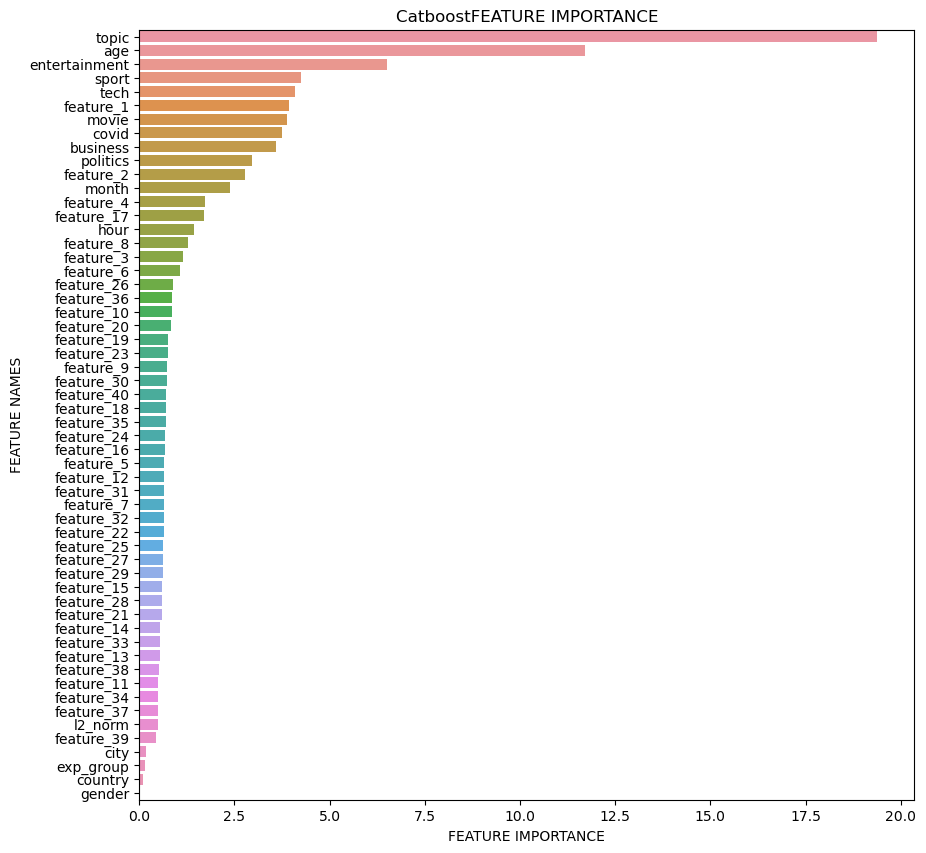

In [43]:
plot_feature_importance(catboost_5.feature_importances_,X_train.columns,'Catboost')

In [44]:
n_depth = 6
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_6 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_6.save_model('catboost_model_6',format="cbm")

ROC_AUC на трейне: 0.7530139679979782
ROC_AUC на тесте: 0.7128114444641571
Accuracy test 0.6638670693441739, Accuracy train 0.6836324137620358


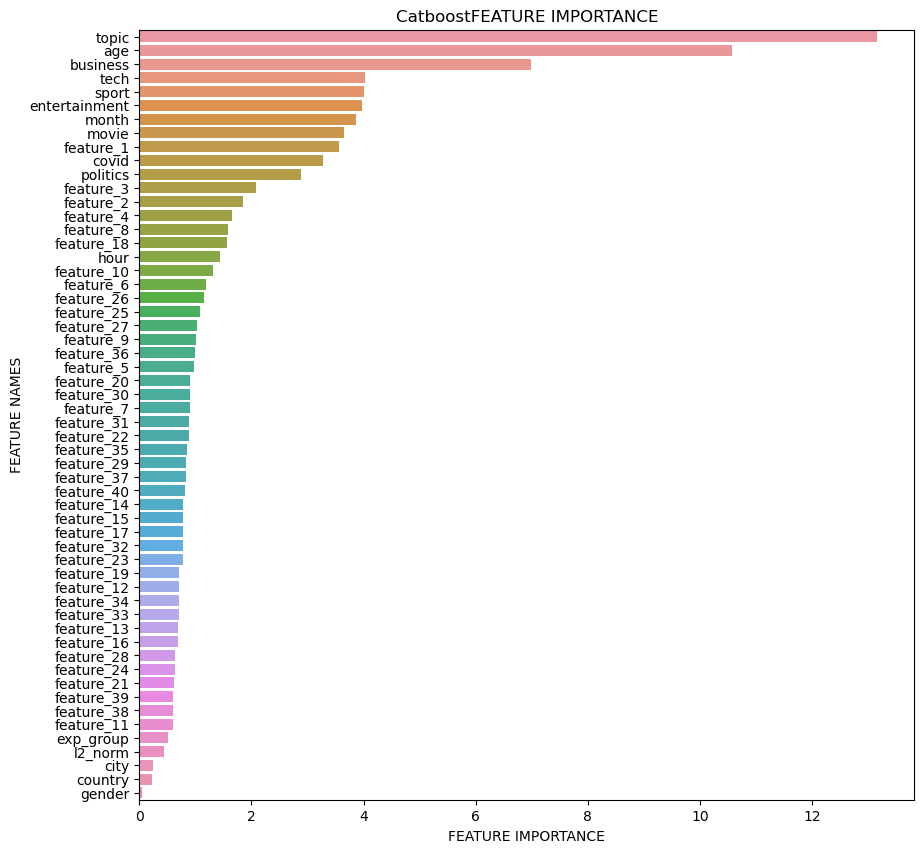

In [45]:
plot_feature_importance(catboost_6.feature_importances_,X_train.columns,'Catboost')

In [46]:
n_depth = 7
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'CrossEntropy',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_7 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_7.save_model('catboost_model_7',format="cbm")

ROC_AUC на трейне: 0.7654348330455404
ROC_AUC на тесте: 0.7110082608960699
Accuracy test 0.6631114605376828, Accuracy train 0.6928050121806965


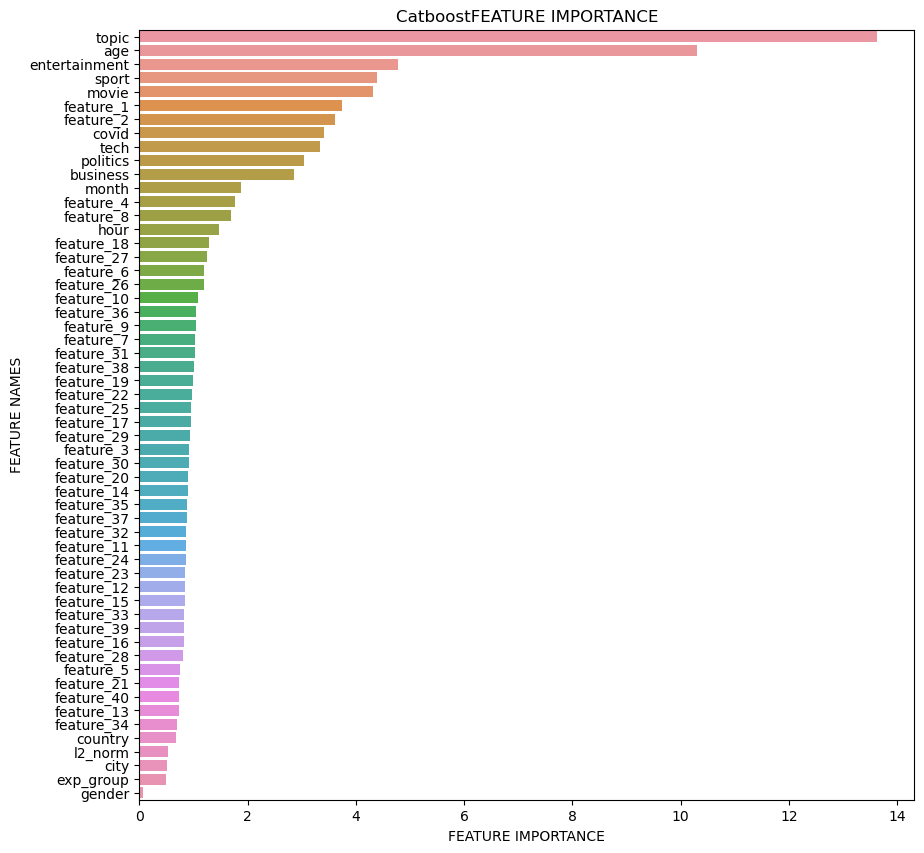

In [47]:
plot_feature_importance(catboost_7.feature_importances_,X_train.columns,'Catboost')

In [48]:
n_depth = 8
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_8 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_8.save_model('catboost_model_8',format="cbm")

ROC_AUC на трейне: 0.7859920167331584
ROC_AUC на тесте: 0.7054395309585748
Accuracy test 0.6590085753360811, Accuracy train 0.7079411661985547


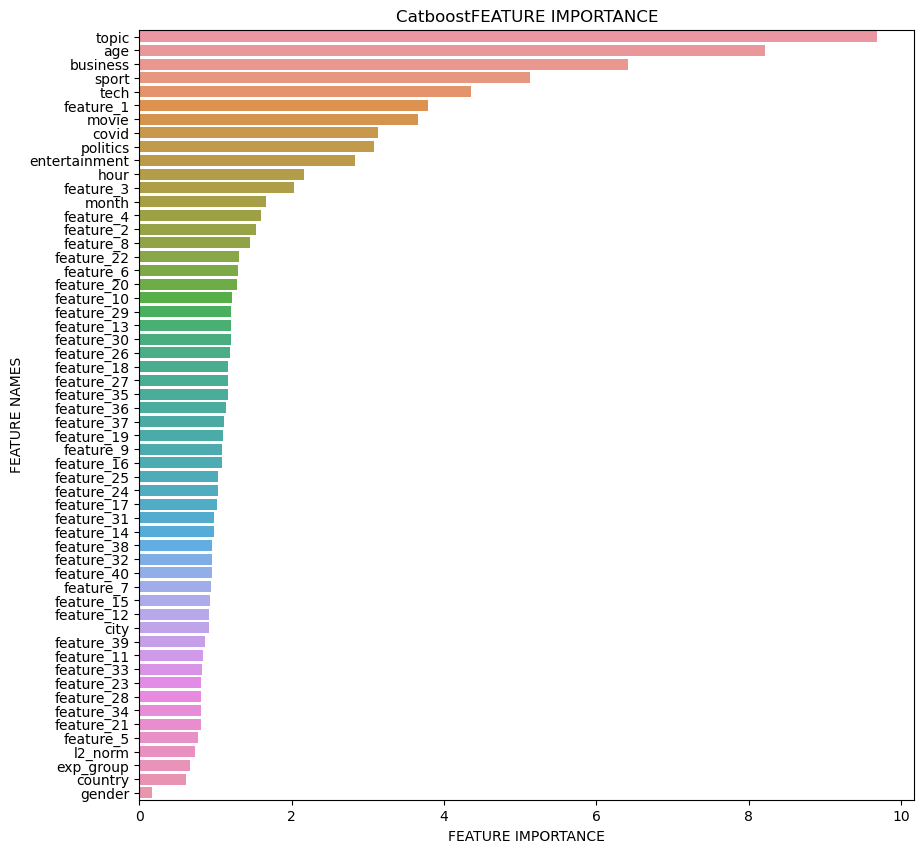

In [49]:
plot_feature_importance(catboost_8.feature_importances_,X_train.columns,'Catboost')

Как видно с ростом глубины деревьев качество на трейне растёт, а на тесте падает, происходит переобучение модели. Оптимальная глубина деревьев - 6.  
К сожалению, после вычисления эмбеддингов постов и выделения новых признаков, по сравнению с работой по unit_02, качество модели не улучшилось.  
Как и в обучении модели, в работе по unit_02, первый по важности признак - topic, затем age. Т.е. пользователь ставит лайк посту в зависимости от темы поста и возраста самого пользователя. Признак l2_norm, по важности играет меньшую роль, что признаки feature_xx.

Запишем таблицу с новыми признаками постов в БД, предварительно присоединим к ней тексты постов.

In [50]:
df_post_data.head()

,post_id,topic,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,l2_norm
0,1,business,0.789075,1.578995,-1.421158,-0.292831,0.196379,-0.482332,-0.172336,-0.252791,...,-0.063520,-0.163439,0.073538,0.063788,0.161548,-0.103752,0.005139,-0.076488,0.091042,15.530115
1,2,business,0.792764,1.521056,-0.897744,0.228620,0.109586,0.125361,-0.163200,0.005960,...,-0.023789,0.242521,-0.117724,-0.096343,-0.138300,0.030694,0.208030,-0.202167,0.169255,15.354099
2,3,business,0.801291,1.223608,-0.669453,1.323420,-0.081454,0.550803,0.049820,-0.241445,...,-0.289171,-0.148392,0.091134,-0.195753,0.005321,0.296334,-0.203689,-0.016341,-0.087571,14.781029
3,4,business,0.867123,0.971223,-1.577186,0.833193,0.841215,-0.292207,0.742463,0.886729,...,0.002015,-0.068738,-0.161402,0.085419,-0.145812,-0.124585,0.186925,0.113004,-0.056141,15.485599
4,5,business,0.411659,0.809848,-0.682364,0.790953,-0.186109,-0.596705,0.169845,-0.758110,...,-0.190245,0.303868,0.195219,-0.255649,-0.011422,-0.278761,-0.014764,-0.087644,-0.064519,15.176049


In [51]:
df_post_data = pd.merge(df_post_data, df_post_text_emb['text'], left_index=True, right_index=True)

In [52]:
df_post_data.head()

,post_id,topic,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,l2_norm,text
0,1,business,0.789075,1.578995,-1.421158,-0.292831,0.196379,-0.482332,-0.172336,-0.252791,...,-0.163439,0.073538,0.063788,0.161548,-0.103752,0.005139,-0.076488,0.091042,15.530115,UK economy facing major risks\n\nThe UK manufa...
1,2,business,0.792764,1.521056,-0.897744,0.228620,0.109586,0.125361,-0.163200,0.005960,...,0.242521,-0.117724,-0.096343,-0.138300,0.030694,0.208030,-0.202167,0.169255,15.354099,Aids and climate top Davos agenda\n\nClimate c...
2,3,business,0.801291,1.223608,-0.669453,1.323420,-0.081454,0.550803,0.049820,-0.241445,...,-0.148392,0.091134,-0.195753,0.005321,0.296334,-0.203689,-0.016341,-0.087571,14.781029,Asian quake hits European shares\n\nShares in ...
3,4,business,0.867123,0.971223,-1.577186,0.833193,0.841215,-0.292207,0.742463,0.886729,...,-0.068738,-0.161402,0.085419,-0.145812,-0.124585,0.186925,0.113004,-0.056141,15.485599,India power shares jump on debut\n\nShares in ...
4,5,business,0.411659,0.809848,-0.682364,0.790953,-0.186109,-0.596705,0.169845,-0.758110,...,0.303868,0.195219,-0.255649,-0.011422,-0.278761,-0.014764,-0.087644,-0.064519,15.176049,Lacroix label bought by US firm\n\nLuxury good...


In [53]:
# Запись таблицы признаков постов в БД.
df_post_data.to_sql("pavel55645_posts_info_features_dl", con=engine, if_exists='replace')